In [63]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [64]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
MAINDIR = "./gdrive/My Drive/EA-test/"
import sys
sys.path.append(MAINDIR)
#Library created to facilitate the generation of clusters
from cluster import calc_clusters, calc_silhouette, plot_silhouette, calc_distorsion, plot_distorsion

df = pd.read_csv(MAINDIR + 'CompleteDataFinal.csv')
df.shape

(21122, 81)

In [0]:
#We will exclude the value 'GK' in 'Preferred Positions' because the metrics for PlayerPlayingPositionData are all 0
df2 = df[~(df['Preferred Positions']  == 'GK')].copy()
#Selection of numerical variables
clm = df2.select_dtypes(exclude='object')
#We will only consider metrics related with the performance of the player, and drop the others
clm = clm.drop(columns=['ID','Age','Value','Wage','Total_languages']) 
clm = clm.columns.to_list()

In [4]:
# We will make the clusters with the top 20 player by 'Overall' and country, So we exclude any country with less than 20 observations
grp = df2.groupby('language_name', as_index=False)['ID'].count()
language_slc = grp[grp.ID>19].language_name.unique()
language_slc

array(['Afrikaans', 'Albanian', 'Arabic', 'Armenian', 'Aymara', 'Bosnian',
       'Bulgarian', 'Chinese', 'Croatian', 'Czech', 'Danish', 'Dutch',
       'English', 'Finnish', 'French', 'Georgian', 'German', 'Greek',
       'Hindi', 'Hungarian', 'Icelandic', 'Irish', 'Italian', 'Japanese',
       'Kongo', 'Korean', 'Lingala', 'Maori', 'Norwegian', 'Peul',
       'Polish', 'Portuguese', 'Quechua', 'Romanian', 'Russian',
       'Serbian', 'Slovak', 'Slovenian', 'South Ndebele',
       'Southern Sotho', 'Spanish', 'Swahili', 'Swati', 'Swedish',
       'Tsonga', 'Tswana', 'Turkish', 'Ukrainian', 'Venda', 'Xhosa',
       'Zulu'], dtype=object)

In [0]:
#Filter first by countries
df3 = df2[df2.language_name.isin(language_slc)]

In [0]:
#Select the top 20 players by 'Overall' and country and add the ID to a list
players = []
for c in language_slc:
  plys = df3[df3.language_name == c][['ID','Overall']].sort_values('Overall',ascending=False)
  players += list(plys['ID'][:20])

In [0]:
 #Filter rows by ID
 df3 = df3[df3['ID'].isin(players)]

In [0]:
#A database of only languages is created to make clusters of them
df3 = df3.groupby('language_name',as_index=False)[['Value','Wage']+clm].mean()

In [9]:
#Use of MinMaxScaler to have all values between 0 and 1
scaler = MinMaxScaler()
x = scaler.fit_transform(df3[clm])
x

array([[0.49215686, 0.47204969, 0.49328993, ..., 0.44420131, 0.60402685,
        0.36961451],
       [0.55294118, 0.55486542, 0.58040765, ..., 0.59080963, 0.53914989,
        0.56462585],
       [0.77647059, 0.76190476, 0.78910724, ..., 0.84463895, 0.7606264 ,
        0.7845805 ],
       ...,
       [0.49215686, 0.47204969, 0.49328993, ..., 0.44420131, 0.60402685,
        0.36961451],
       [0.49215686, 0.47204969, 0.49328993, ..., 0.44420131, 0.60402685,
        0.36961451],
       [0.49215686, 0.47204969, 0.49328993, ..., 0.44420131, 0.60402685,
        0.36961451]])

In [0]:
#Function to calculate hierarchical clusters from 2 to 30 groups
data_cl = calc_clusters(x)

In [0]:
#Calculate silhoutte average
#Return a column with the silhoutte average per cluster
data_cl = calc_silhouette(x, data_cl)

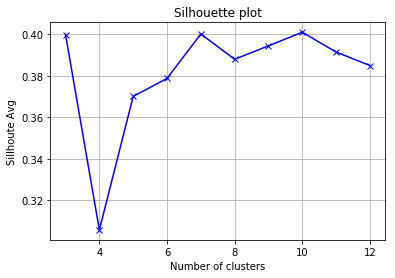

In [45]:
#Plot silhoutte average
plot_silhouette(data_cl, end= 13)

By the silhouette average, 2 is the optimal number of cluster, but to have more group we will take the second optimal number 7

In [0]:
#Calculate distorsion for Elbow method
data_cl  = calc_distorsion(x, data_cl)

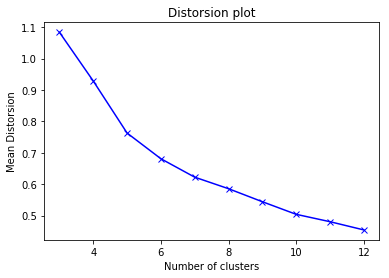

In [48]:
#Plot distorsion for Elbow method
plot_distorsion(data_cl, end=13)

Although 5 looks like a candidate, it's not entirely clear, so we take 7

In [0]:
# Add clusters column to dataframe df3 (dataframe with only metrics by language)
b = pd.Series(data_cl.loc[7,'clusterList'],name = 'Cluster_language')
df4 = pd.concat([df3,b], axis=1)

In [54]:
#Evaluate cluster metrics
df4.groupby('Cluster_language',as_index=False).agg({'language_name':'count','Value':'mean','Wage':'mean','Overall':'mean','Stamina':'mean'})

,Cluster_language,language_name,Value,Wage,Overall,Stamina
0,1,2,6.375000e+04,300.000000,66.700000,71.200000
1,2,4,1.973000e+06,10487.500000,65.675000,66.687500
2,3,4,3.599000e+07,137745.000000,84.805000,77.722500
3,4,9,1.009524e+07,39327.633429,76.391784,74.349883
4,5,15,9.177164e+06,38399.180267,74.685311,73.859878
5,6,9,2.960000e+06,6550.000000,72.600000,71.950000
6,7,8,4.534616e+06,20658.712971,72.076400,71.905176


Similar to the countries cluster, the languages clusters are grouped from highest to lowest performance of 'Overall' , being 3 the highest performance, then 4, 5, 6, 7, 1 and 2

In [60]:
#Then, we change the cluster ID so that number 1 is the one with the highest performance and so on
df4.Cluster_language.replace({3:1,4:2,5:3,6:4,7:5,1:6,2:7}, inplace=True)
df4.groupby('Cluster_language',as_index=False).agg({'language_name':'count','Value':'mean','Wage':'mean','Overall':'mean','Stamina':'mean'})

,Cluster_language,language_name,Value,Wage,Overall,Stamina
0,1,4,3.599000e+07,137745.000000,84.805000,77.722500
1,2,9,1.009524e+07,39327.633429,76.391784,74.349883
2,3,15,9.177164e+06,38399.180267,74.685311,73.859878
3,4,9,2.960000e+06,6550.000000,72.600000,71.950000
4,5,8,4.534616e+06,20658.712971,72.076400,71.905176
5,6,2,6.375000e+04,300.000000,66.700000,71.200000
6,7,4,1.973000e+06,10487.500000,65.675000,66.687500


In [0]:
#Save data frame of cluster
df4.to_csv(MAINDIR+'languageCLusters.csv',index=False)